## 玉山人工智慧公開挑戰賽2019夏季賽 - 台灣不動產AI神預測 

- House price: Predict sales prices
- 購買屬於自己的房子，是我們一生中的大事，評估房子的好壞，不僅要考慮房子的大小、屋齡，甚至連附近的生活機能和未來發展性都是一大考量因素。然而在眾多的考量中，什麼才是影響房價高低至關重要的因素呢？

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm


from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score


from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso
import lightgbm as lgb

import scipy.stats as stats
import math
import gc


import hyperopt
from hyperopt import hp
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import fmin
import csv
from timeit import default_timer as timer
from hyperopt import STATUS_OK, hp, tpe, Trials, fmin
import ast

from numpy.random import RandomState



import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Load the data

In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

print("Train ", train.shape[0], "sales, and ", train.shape[1], "features" )
print("Test ", test.shape[0], "sales, and ", test.shape[1], "features" )

Train  60000 sales, and  235 features
Test  10000 sales, and  234 features


### EDA

There are 60,000 instances of training data and 10000 of test data. Total number of attributes equals 235, of which 233 is quantitative, Id (qualitative) and SalePrice. -> all are quantitative except ID

- **Missing Value**: 4 features have missing value in both train and test data: 'village_income_median', 'txn_floor', 'parking_price', 'parking_area'

- **Normal Distributaion on total price**: total_price doesn't follow normal distribution, so before performing regression it has to be transformed -> use standardisation since log total price follow gaussian distribution

- Data is non-linear

In [3]:
quantitative = [f for f in train.columns if train[f].dtypes != 'object']
#quantitative.remove('total_price')
qualitative = [f for f in train.columns if train[f].dtypes == 'object']

In [4]:
print("train data type: ", train.get_dtype_counts())
print("test data type: ", test.get_dtype_counts())

train data type:  float64     37
int64      197
object       1
dtype: int64
test data type:  float64     36
int64      197
object       1
dtype: int64


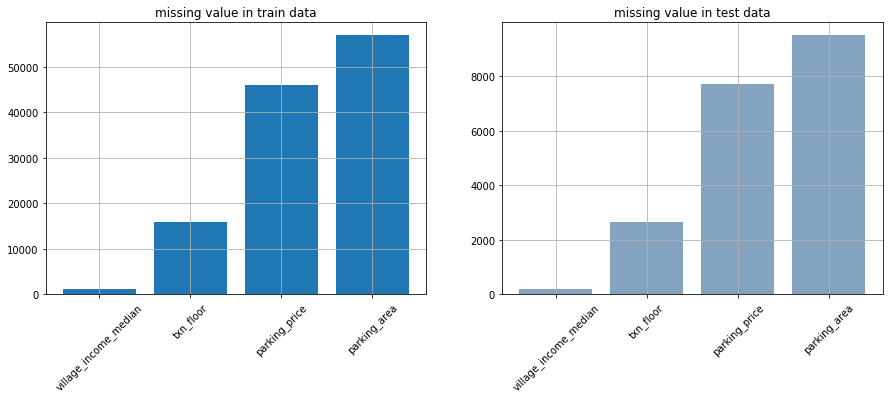

In [5]:
tr_missing = train.isnull().sum()
tr_missing = tr_missing[tr_missing > 0]
tr_missing.sort_values(inplace=True)
tr_missing = pd.DataFrame(tr_missing).reset_index()
tr_missing = tr_missing.rename(columns = {"index": "features", 0:"count"})

te_missing = test.isnull().sum()
te_missing = te_missing[te_missing > 0]
te_missing.sort_values(inplace=True)
te_missing = pd.DataFrame(te_missing).reset_index()
te_missing = te_missing.rename(columns = {"index": "features", 0:"count"})


def plot_missing(df_train, df_test):
    
    plt.figure(figsize=(15, 5)) 
    
    plt.subplot(1,2,1)
    plt.grid(b=None) # no grid line
    plt.bar(df_train["features"], df_train["count"])
    plt.title("missing value in train data", loc='center')
    plt.xticks(rotation=45)
    
    plt.subplot(1,2,2)
    plt.grid(b=None) # no grid line
    plt.bar(df_test["features"], df_test["count"], color=(0.2, 0.4, 0.6, 0.6))
    plt.title("missing value in test data", loc='center')
    plt.xticks(rotation=45)
    
    plt.show()
    
plot_missing(tr_missing, te_missing)

Text(0.5, 1.0, 'Normal Distribution with log transform for total price (train)')

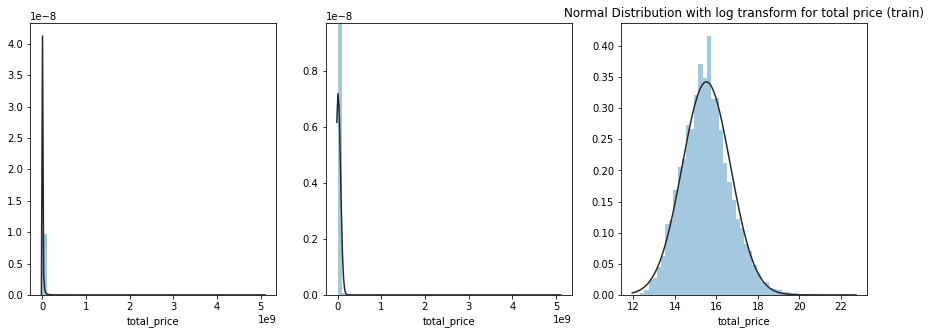

In [6]:
y = train['total_price']
log_price = train["total_price"].apply(lambda row: math.log(row))

f, axes = plt.subplots(1, 3, figsize=(15,5))

sns.distplot(y, kde=False, fit=stats.johnsonsu, ax = axes[0])
plt.title('Johnson SU')

sns.distplot(y, kde=False, fit=stats.norm, ax = axes[1])
plt.title('Normal Distribution')

sns.distplot(log_price, kde=False, fit=stats.norm, ax = axes[2])
plt.title('Normal Distribution with log transform for total price (train)')

In [7]:
# The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution
warnings.filterwarnings("ignore")

test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)

# not reject null hypothesis -> features with normal distribution
print("features with normal distribution: \n", list(pd.DataFrame(normal[normal==False]).reset_index()["index"])) 

features with normal distribution: 
 ['I_index_5000', 'I_index_10000', 'II_index_5000', 'II_index_10000', 'III_index_5000', 'III_index_10000', 'IV_index_10000', 'V_index_5000', 'V_index_10000', 'VI_index_5000', 'VI_index_10000', 'VII_index_5000', 'VII_index_10000', 'VIII_index_5000', 'VIII_index_10000', 'IX_index_10000', 'X_index_5000', 'X_index_10000', 'XII_index_5000', 'XII_index_10000', 'XIV_index_5000', 'XIV_index_10000']


In [8]:
# Data is non-linear (skip first -> take too long)

# features = [col for col in train.columns if col not in ["building_id", "total_price"]]
# model = TSNE(n_components=2, random_state=0, perplexity=50)

# X = train[features].fillna(0).values
# tsne = model.fit_transform(X)

# std = StandardScaler()
# s = std.fit_transform(X)

# pca = PCA(n_components=30)
# pca.fit(s)
# pc = pca.transform(s)
# kmeans = KMeans(n_clusters=5)
# kmeans.fit(pc)

# fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
# sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
# print(np.sum(pca.explained_variance_ratio_))

### Handle Missing Value
- village_income_median
- txn_floor
- parking_price
- parking_area

Note: 
1. whether should comebine train and test to replace the missing value 
2. strong assumption on if park_way==2 -> parking_area & parking_price = 0 <br/>
    (found: parking_way==2 -> parking_price=na and parking_area=na)



In [9]:
test["total_price"] = -1
all_df = pd.concat([train, test])

print("# of missing value in village income median (all): ", all_df["village_income_median"].isnull().sum())
print("# of missing value in village income median (train): ", train["village_income_median"].isnull().sum())
print("# of missing value in village income median (test): ", test["village_income_median"].isnull().sum())

# of missing value in village income median (all):  1326
# of missing value in village income median (train):  1142
# of missing value in village income median (test):  184


In [10]:
#----------------------------------------------
# remove column with no variation
#----------------------------------------------

print("data shape: ", all_df.shape)
all_df = all_df.loc[:,all_df.apply(pd.Series.nunique) != 1]
print("data shape after removing columns with no variation: ", all_df.shape)

data shape:  (70000, 235)
data shape after removing columns with no variation:  (70000, 213)


In [11]:
# get possiblely categorical variable
categorical_var=[]
for col in all_df:
    if len(all_df[col].unique())>1 and all_df[col].dtypes=="int64":
        #print (col, "-> unique value: ", train[col].unique())
        categorical_var.append(col)
print(categorical_var)

['building_material', 'city', 'txn_dt', 'total_floor', 'building_type', 'building_use', 'building_complete_dt', 'parking_way', 'town', 'village', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_index_50', 'I_100', 'I_250', 'I_500', 'I_index_500', 'I_1000', 'I_index_1000', 'I_5000', 'I_10000', 'II_10', 'II_50', 'II_index_50', 'II_100', 'II_250', 'II_500', 'II_index_500', 'II_1000', 'II_index_1000', 'II_5000', 'II_10000', 'III_10', 'III_50', 'III_index_50', 'III_100', 'III_250', 'III_500', 'III_index_500', 'III_1000', 'III_index_1000', 'III_5000', 'III_10000', 'IV_10', 'IV_50', 'IV_index_50', 'IV_100', 'IV_250', 'IV_500', 'IV_index_500', 'IV_1000', 'IV_index_1000', 'IV_5000', 'IV_index_5000', 'IV_10000', 'V_10', 'V_50', 'V_index_50', 'V_100', 'V_250', 'V_500', 'V_index_500', 'V_1000', 'V_index_1000', 'V_5000', 'V_10000', 'VI_10', 'VI_50', 'VI_index_50', 'VI_100', 'VI_250', 'VI_500', 'VI_index_500', 'VI_1000', 'VI_index_1000', 'VI_5000', 'VI_10000', 'VII_10', 'VII_50', 

In [12]:
#----------------------------------------------
# missing value in village_income_median
#----------------------------------------------

missing_income_village = np.unique(all_df[pd.isnull(all_df["village_income_median"])][["village"]])
print("# of village missing median income: ", len(missing_income_village))

missing_income_village_tr = np.unique(train[pd.isnull(train["village_income_median"])][["village"]])
print("# of village missing median income (train): ", len(missing_income_village_tr))

a = all_df[all_df["village"].isin(missing_income_village)][["village", "village_income_median"]]
village_have_income_replace = np.unique(a[pd.notnull(a["village_income_median"])][["village"]])
print("# of village can be replace by mean village income: ", len(village_have_income_replace))
print("# of village no replacement: ", len(set(missing_income_village)-set(village_have_income_replace)))


# replace village_have_income_replace with median
for item in village_have_income_replace:
    all_village_median_income = all_df.groupby(by="village")["village_income_median"].agg("median")
    all_df["village_income_median"] = all_df.apply(lambda row:  all_village_median_income[item]
                                   if (row["village"]==item and pd.isnull(row["village_income_median"])) 
                                   else row["village_income_median"], axis=1)

# replace those cannot find with median of town
for item in list(set(all_df["town"])):
    all_town_median_income = all_df.groupby(by="town")["village_income_median"].agg("median")
    all_df["village_income_median"] = all_df.apply(lambda row:  all_town_median_income[item]
                                   if (row["town"]==item and pd.isnull(row["village_income_median"])) 
                                   else row["village_income_median"], axis=1)

# check no na
print("# of missing value in village_income_median ", all_df["village_income_median"].isnull().sum())

# of village missing median income:  105
# of village missing median income (train):  102
# of village can be replace by mean village income:  27
# of village no replacement:  78
# of missing value in village_income_median  0


In [13]:
#----------------------------------------------
# missing value in txn_floor
#----------------------------------------------

# city with na txn_floor
city_na_floor = np.unique(all_df[pd.isnull(all_df["txn_floor"])][["city"]])

b = all_df[all_df["city"].isin(city_na_floor)]
city_with_floor = np.unique(b[pd.notnull(b["txn_floor"])][["city"]])

# check whether all na floor can be replace with floor data by existing data
print("# of city with no txn_floor data: ", len(set(city_na_floor) - set(city_with_floor)))

# replace those na in txn_floor with the existing data

city_txn_floor_data = all_df.groupby(by=["city", "txn_floor"]).size().reset_index().rename(columns={0: "count"})
city_txn_floor_data["total_count"] = city_txn_floor_data["city"].map(city_txn_floor_data.groupby("city")["count"].agg("sum"))

city_txn_floor_data["weight"] = city_txn_floor_data["count"]/city_txn_floor_data["total_count"]
city_txn_floor_data["max_count"] = city_txn_floor_data["city"].map(city_txn_floor_data.groupby("city")["count"].agg("max"))

city_txn_floor_data = city_txn_floor_data[city_txn_floor_data["count"]==city_txn_floor_data["max_count"]][["city", "txn_floor"]]
city_txn_floor_data = city_txn_floor_data.rename(columns={"txn_floor":"txn_floor_n"})

all_df = pd.merge(all_df, city_txn_floor_data, how="left", on = "city")

def replace_txn_floor(row):
    if pd.isnull(row["txn_floor"]):
        row["txn_floor"] = row["txn_floor_n"]
    else:
        row["txn_floor"]
    return row["txn_floor"]
all_df["txn_floor"] = all_df.apply(replace_txn_floor, axis=1)
del all_df["txn_floor_n"]

# check no na
print("# of missing value in txn_floor ", all_df["txn_floor"].isnull().sum())

# of city with no txn_floor data:  0
# of missing value in txn_floor  0


In [14]:
#----------------------------------------------
# missing value in parking_price
#----------------------------------------------

# parking_way==2 -> parking_price=na and parking_area=na
print(all_df.groupby(by=["parking_way"])["parking_price"].agg("mean"))
print(all_df[(all_df["parking_way"]==2)&(pd.notnull(all_df["parking_area"]))&(pd.notnull(all_df["parking_price"]))].shape)

def replace_parking_price(row):
    if pd.isnull(row["parking_price"]) and row["parking_way"]==2:
        row["parking_price"] = 0
    else:
        row["parking_price"]
    return row["parking_price"]

all_df["parking_price"] = all_df.apply(replace_parking_price, axis=1)
print("# of missing value in parking price: ", all_df["parking_price"].isnull().sum())

parking_way
0    55646.055081
1    30784.672629
2             NaN
Name: parking_price, dtype: float64
(0, 213)
# of missing value in parking price:  0


In [15]:
#----------------------------------------------
# missing value in parking_area
#----------------------------------------------

# parking_way==2 -> parking_price=na and parking_area=na

def replace_parking_area(row):
    if pd.isnull(row["parking_area"]) and row["parking_way"]==2:
        row["parking_area"] = 0       
    else:
        row["parking_area"]
    return row["parking_area"]
all_df['parking_area'] = all_df.apply(replace_parking_area, axis=1)

all_df['parking_area'] = all_df.groupby(by=["village", "parking_way"])['parking_area'].transform(lambda x: x.fillna(x.median()))
all_df['parking_area'] = all_df.groupby(by=["town", "parking_way"])['parking_area'].transform(lambda x: x.fillna(x.median()))                                                                                                  
all_df['parking_area'] = all_df.groupby(by=["city", "parking_way"])['parking_area'].transform(lambda x: x.fillna(x.median()))                                           
all_df["parking_area"] = all_df["parking_area"].fillna(0)

print("# of missing value in parking area: ", all_df["parking_area"].isnull().sum())

# of missing value in parking area:  0


In [16]:
#----------------------------------------------
# Standardisation continuous data (note: should separate train and test?)
#----------------------------------------------

all_df.drop("building_id", axis=1, inplace=True)
train1 = all_df[:len(train)]
test1 = all_df[len(train):]

# exclude target variable
standardise_list = list(set(all_df.columns)-set(categorical_var))
standardise_list.remove("total_price")
standarize = lambda x: (x-x.mean()) / x.std()

for col in standardise_list:
    train1[col] = standarize(train1[col])
    test1[col] = standarize(test1[col])

In [ ]:
# make categorical variable one hot encode (use too many memory)
# all_df1 = pd.concat([train1, test1])
# all_df1 = pd.get_dummies(all_df1, columns = categorical_var)

In [ ]:
# check features correlation with target (skip first)

# corr_sale=train1.corr()["total_price"]

# fig, ax = plt.subplots(figsize = (50, 50))
# #corr_sale[np.argsort(corr_sale, axis=0)[::-1]].plot(kind='barh')
# corr_sale[(corr_sale>0.05)].sort_values(ascending= False).plot(kind='barh')
# plt.tick_params(labelsize=12)
# plt.ylabel("Pearson correlation",size=12)
# plt.title('Correlated features with Sale Price', size=13)
# plt.tight_layout()

### Model

- linear regression: 745
- lasso: 816
- lgbm

In [17]:
# make categorical variable as factor to avoid being treated as numeric variable
for col in categorical_var:
    train1[col] = train1[col].astype('category')
    test1[col] = test1[col].astype('category')

In [18]:
train2 = train1.drop('total_price', axis=1)
test2 = test1.drop("total_price", axis=1)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train2, train1["total_price"], test_size=0.2, random_state=0)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


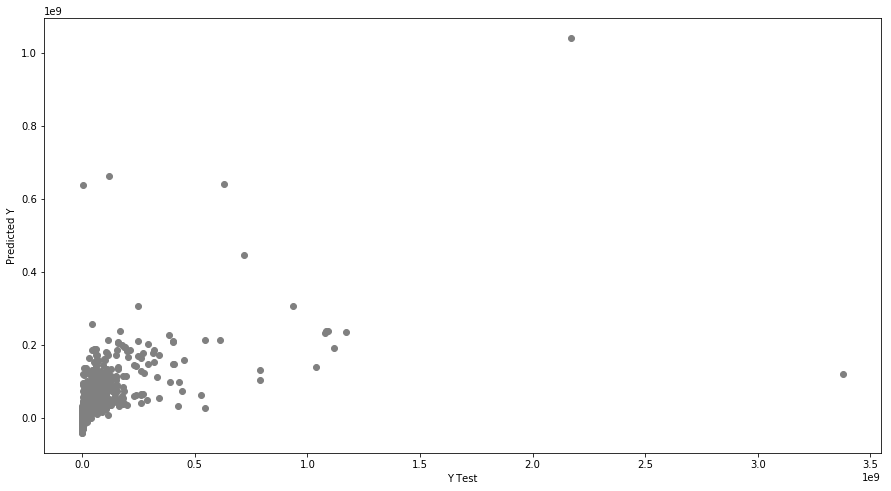

MAE: 9642841.477910597
MSE: 1924506739314955.5
RMSE: 43869200.34961836
R square: 0.3257905751090625


In [20]:
#----------------------------------------------
# linear regression
#----------------------------------------------

from sklearn.metrics import r2_score
lm = LinearRegression()
model = lm.fit(X_train,y_train)
print(lm)

predictions = lm.predict(X_test)
predictions= predictions.reshape(-1,1)

plt.figure(figsize=(15,8))
plt.scatter(y_test, predictions, color = "grey")
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print("R square:", r2_score(y_test, predictions))


output_linear_reg = test[["building_id"]]
output_linear_reg["total_price"] = lm.predict(test2).reshape(-1,1)
output_linear_reg.to_csv("submission_linear_reg.csv", index=False)

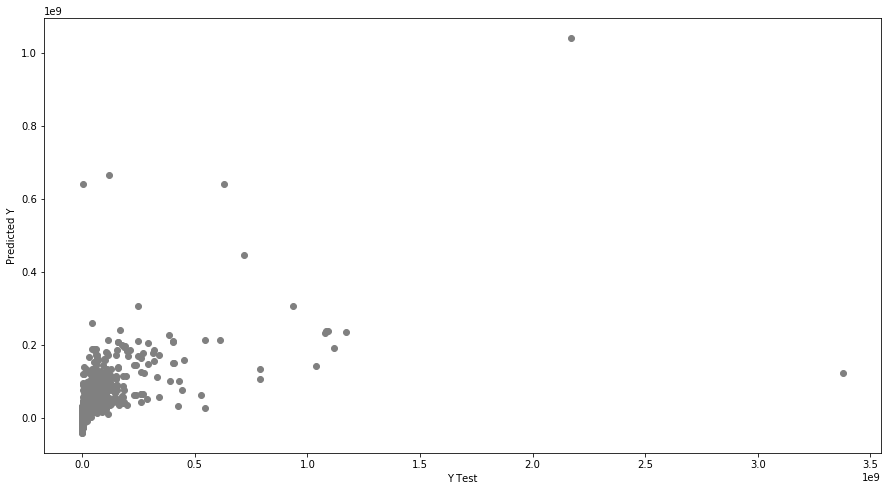

MAE: 9592124.427024605
MSE: 1924476957614698.5
RMSE: 43868860.91084083
R square: 0.3258010084853622


In [21]:
#----------------------------------------------
# lasso 
#----------------------------------------------

lasso = Lasso()
model2 = lasso.fit(X_train,y_train)

predictions = lasso.predict(X_test)
predictions= predictions.reshape(-1,1)

plt.figure(figsize=(15,8))
plt.scatter(y_test, predictions, color = "grey")
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print("R square:", r2_score(y_test, predictions))

output_lasso = test[["building_id"]]
output_lasso["total_price"] = lasso.predict(test2).reshape(-1,1)
output_lasso.to_csv("submission_lasso.csv", index=False)

In [ ]:
#----------------------------------------------
# lgbm
#----------------------------------------------

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmsle',
    'num_leaves': 13,
    'max_depth': -1, 
    'learning_rate': 0.1,
    'verbose': 1}

num_round = 1000

n_iters = 5
predictions = np.zeros(len(test2))


for i in range(n_iters):   
       
    x_train, x_valid, y_train, y_valid = train_test_split(train2, train1["total_price"], 
                                                          test_size=0.2, random_state=i)
    
    trn_data = lgb.Dataset(x_train, label=y_train)
    val_data = lgb.Dataset(x_valid, label=y_valid)
    
    model = lgb.train(params, trn_data, num_round, 
                      valid_sets = [val_data], 
                      verbose_eval=1000)
                      
    predictions += model.predict(test2, num_iteration = model.best_iteration) / n_iters
    

output_lgbm = test[["building_id"]]
output_lgbm["total_price"] = predictions
output_lgbm.to_csv("submission_lgbm.csv", index=False)    

In [ ]:
# from sklearn.model_selection import StratifiedKFold

# target = train1["total_price"]
# # use x fold to check since run so slow
# folds = StratifiedKFold(n_splits=5, shuffle=False, random_state=0)
# oof = np.zeros(len(train2))
# predictions = np.zeros(len(test2))

# for fold_, (trn_idx, val_idx) in enumerate(folds.split(train2.values, target.values)):
    
#     print("Fold {}".format(fold_))
    
#     X_train, X_test = train2.iloc[trn_idx], train2.iloc[val_idx]
#     y_train, y_test = target.iloc[trn_idx], target.iloc[val_idx]
    
#     # get 10 oof data -> cuz cv=10
#     lm.fit(X_train,y_train)
#     oof[val_idx] = lm.predict(X_test)
    
#     predictions += lm.predict(test2) / folds.n_splits

# print("CV score: {:<8.5f}".format(roc_auc_score(train1["total_price"], oof)))

#--------- till here

In [ ]:
# sns.boxplot(x="city", y='total_price', data=train1, palette="Blues")

In [ ]:
# corr_sale=train_1.corr()["total_price"]

# fig, ax = plt.subplots(figsize = (50, 50))
# corr_sale[np.argsort(corr_sale, axis=0)[::-1]].plot(kind='barh')
# plt.tick_params(labelsize=12)
# plt.ylabel("Pearson correlation",size=12)
# plt.title('Correlated features with Sale Price', size=13)
# plt.tight_layout()

In [ ]:
# corr = train_1.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
# f, ax = plt.subplots(figsize=(11, 11))
# sns.heatmap(corr, vmin=-0.8, vmax=0.8, square=True)
# f.tight_layout()

In [ ]:
# check fake data in test

# test1 = test.drop(['building_id'], axis=1)
# test1.shape

# unique_samples = []
# unique_count = np.zeros_like(test1)

# feature = [col for col in train.columns if col not in ["building_id", "total_price"]]

# for i in range(len(feature)):
#     _, index_, count_ = np.unique(test1.loc[:, feature[i]], return_counts=True, return_index=True)
#     unique_count[index_[count_ == 1], i] += 1

# # Samples which have unique values are real the others are fake
# real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
# synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

# print("# of real data: ", len(real_samples_indexes))
# print("# of fake data: ", len(synthetic_samples_indexes))